# Cas Kaggle ApC - Mushroom Classification - Problema de classificació binària

## Descripció del dataset
Aquest dataset inclou descripcions de mostres hipotètiques que corresponen a 23 espècies de bolets de les famílies Agaricus i Lepiota. Cada espècia s'identifica com a "definitivament comestible" (definitely edible), com a "definitivament verinosa" (definitely poisonous) o "comestibilitat desconeguda" (unknown edibility).

**Objectiu**: Preveure si un bolet concret és comestible o no basat en les seves característiques físiques.

**Important a tenir en compte**: Estem davant d'un cas on la seguretat és molt important, per tant els "falsos negatius" poden ser letals. És degut a això que haurem de prioritzar el **recall** de la classe "verinosa" (poisonous).


## 1. Setup and Data Loading


In [1]:
# Importació de llibreries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Carreguem el dataset
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data'
column_names = [
    'class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
    'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
    'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
    'stalk-surface-below-ring', 'stalk-color-above-ring',
    'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number',
    'ring-type', 'spore-print-color', 'population', 'habitat'
]

df = pd.read_csv(url, names=column_names)
print("Dataset loaded from UCI repository successfully!")

print(f"\nFirst rows:")
df.head()


Dataset loaded from UCI repository successfully!

First rows:


,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


## 2. Exploratory Data Analysis (EDA)


In [3]:
# Dataset overview
print("Dataset shape:", df.shape)
print("\nData types:")
print(df.dtypes.value_counts())
print("\nDuplicates:", df.duplicated().sum())


Dataset shape: (8124, 23)

Data types:
object    23
Name: count, dtype: int64

Duplicates: 0


In [4]:
# Target distribution
print("Target class distribution:")
print(df['class'].value_counts())
print("\nPercentage:")
print(df['class'].value_counts(normalize=True) * 100)


Target class distribution:
class
e    4208
p    3916
Name: count, dtype: int64

Percentage:
class
e    51.797144
p    48.202856
Name: proportion, dtype: float64


In [5]:
# Missing values check
print("Missing values represented as '?':")
missing_data = []
for col in df.columns:
    missing_count = (df[col] == '?').sum()
    if missing_count > 0:
        missing_data.append({'Feature': col, 'Missing': missing_count, 'Percentage': f"{missing_count/len(df)*100:.2f}%"})

if missing_data:
    print(pd.DataFrame(missing_data))
else:
    print("No missing values found")


Missing values represented as '?':
      Feature  Missing Percentage
0  stalk-root     2480     30.53%


In [6]:
# Feature cardinality
print("Unique values per feature:\n")
for col in df.columns:
    unique_count = df[col].nunique()
    print(f"{col:30} {unique_count} unique values")
    
# Check for zero-variance features
zero_var_features = [col for col in df.columns if df[col].nunique() == 1]
if zero_var_features:
    print(f"\nZero variance features: {zero_var_features}")


Unique values per feature:

class                          2 unique values
cap-shape                      6 unique values
cap-surface                    4 unique values
cap-color                      10 unique values
bruises                        2 unique values
odor                           9 unique values
gill-attachment                2 unique values
gill-spacing                   2 unique values
gill-size                      2 unique values
gill-color                     12 unique values
stalk-shape                    2 unique values
stalk-root                     5 unique values
stalk-surface-above-ring       4 unique values
stalk-surface-below-ring       4 unique values
stalk-color-above-ring         9 unique values
stalk-color-below-ring         9 unique values
veil-type                      1 unique values
veil-color                     4 unique values
ring-number                    3 unique values
ring-type                      5 unique values
spore-print-color             

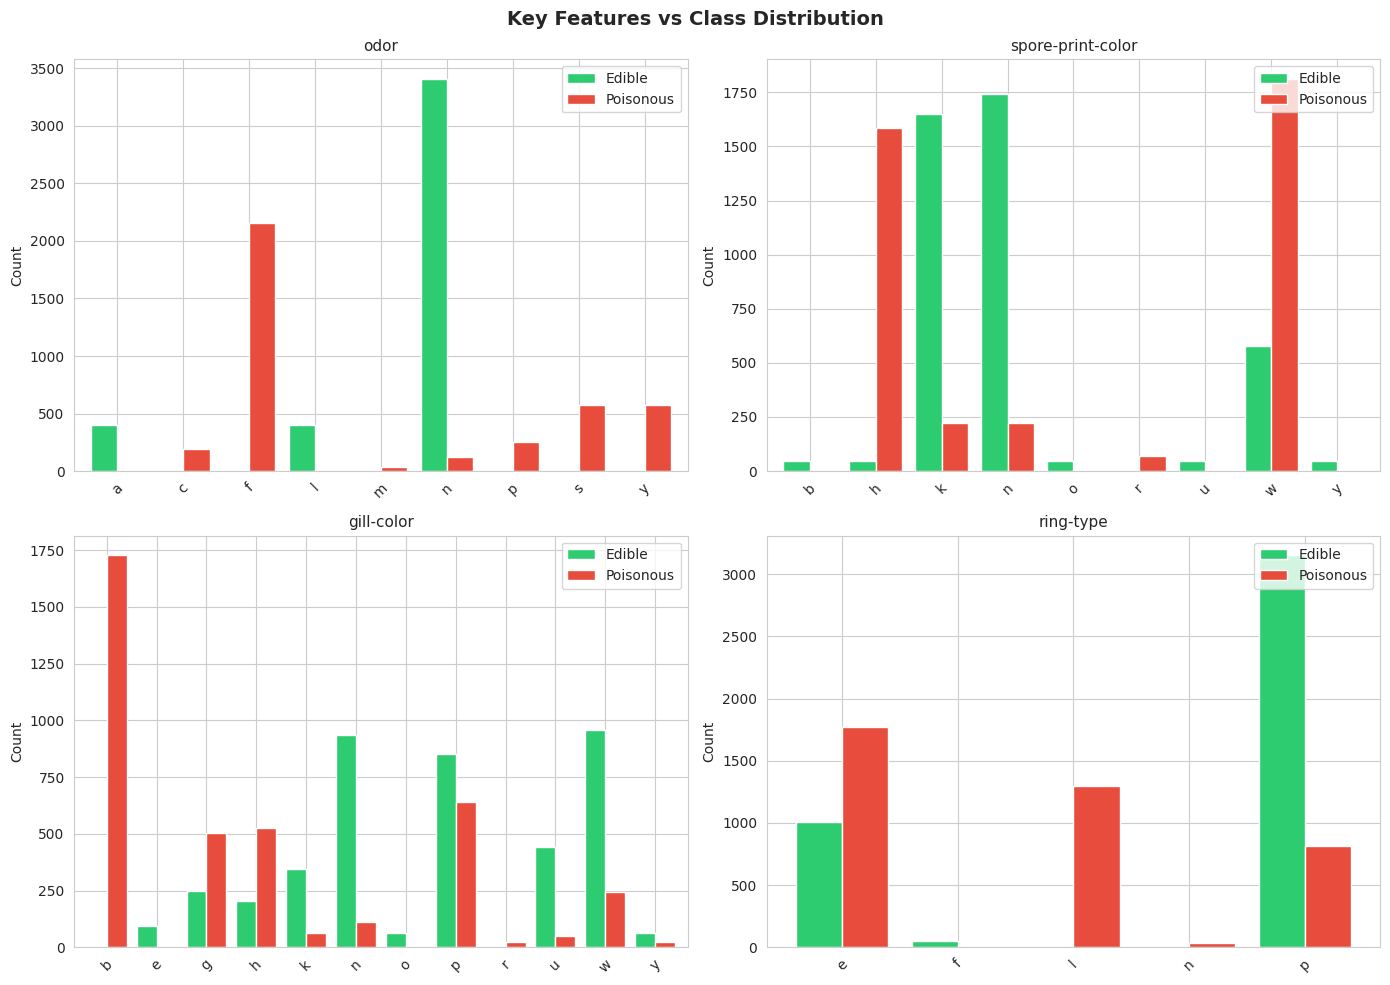

In [7]:
# Bivariate analysis - key features vs target
key_features = ['odor', 'spore-print-color', 'gill-color', 'ring-type']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Key Features vs Class Distribution', fontsize=14, fontweight='bold')

for idx, feature in enumerate(key_features):
    ax = axes[idx // 2, idx % 2]
    
    crosstab = pd.crosstab(df[feature], df['class'])
    crosstab.plot(kind='bar', ax=ax, color=['#2ecc71', '#e74c3c'], width=0.8)
    
    ax.set_title(f'{feature}', fontsize=11)
    ax.set_xlabel('')
    ax.set_ylabel('Count')
    ax.legend(['Edible', 'Poisonous'], loc='upper right')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [8]:
# Odor feature (normalment és la feature més discriminativa, tal com hem vist en l'anàlisis anterior)
print("Odor distribution by class:")
odor_class = pd.crosstab(df['odor'], df['class'], margins=True)
print(odor_class)

# Check if any odor value perfectly predicts class
print("\n🔍 Odor values and their class association:")
for odor_val in df['odor'].unique():
    subset = df[df['odor'] == odor_val]
    class_dist = subset['class'].value_counts()
    if len(class_dist) == 1:
        print(f"  '{odor_val}': 100% {class_dist.index[0]} ({len(subset)} samples)")


Odor distribution by class:
class     e     p   All
odor                   
a       400     0   400
c         0   192   192
f         0  2160  2160
l       400     0   400
m         0    36    36
n      3408   120  3528
p         0   256   256
s         0   576   576
y         0   576   576
All    4208  3916  8124

🔍 Odor values and their class association:
  'p': 100% p (256 samples)
  'a': 100% e (400 samples)
  'l': 100% e (400 samples)
  'f': 100% p (2160 samples)
  'c': 100% p (192 samples)
  'y': 100% p (576 samples)
  's': 100% p (576 samples)
  'm': 100% p (36 samples)


### Análisis final

1. **Mida Dataset**: 8124 bolets amb 23 features (totes categòriques)
   - Això ens indica que el dataset és prou gran per l'entrenament, a més a més el fet de que totes siguin categòriques ens indica que els models basats en arbres són ideals per un cas com el nostre.

2. **Balanceig de classes**: El dataset està molt ben balancejat (~52% edible, ~48% poisonous)
   - Per tant ja sabem que no necessitem tècniques de "resampling".

3. **Valors faltants**: Hem observat que la feature `stalk-root` té prop del 30% de valors faltants (?).
   - Necessitem gestionar això abans de modelar, ja sigui afegint valors o fent "drops". 

4. **Features amb zero variància**: `veil-type` té un únic valor en tots els casos.
   - Sabem per tant que no ens aporta cap tipus d'informació i en el preprocessament de dades la podrem esborrar.

5. **Features Discriminants**: 
   - **Odor** és molt discriminativa - alguns valors preveuen per si sols la classe a la perfecció.
   - **Spore-print-color** i **gill-color** també mostren força discriminació.
   - Aquest4es features molt possiblement dominaran la predicció del nostre model.

6. **Separabilitat perfecta**: Algunes features amb uns valors concrets estan 100% associades a una classe.
   - Sabent això, en principi hauríem de ser capaços d'aconseguir un model amb una alta "accuracy".


## 3. Data preprocessing

In [9]:
# Handle missing values
df_clean = df.replace('?', np.nan)

for col in df_clean.columns:
    if df_clean[col].isnull().sum() > 0:
        mode_value = df_clean[col].mode()[0]
        df_clean[col] = df_clean[col].fillna(mode_value)
        print(f"Filled {col} missing values with mode: {mode_value}")

print(f"Remaining missing values: {df_clean.isnull().sum().sum()}")


Filled stalk-root missing values with mode: b
Remaining missing values: 0


In [10]:
# Remove zero-variance features
df_clean = df_clean.drop('veil-type', axis=1)
print(f"Removed 'veil-type' (zero variance)")
print(f"New shape: {df_clean.shape}")


Removed 'veil-type' (zero variance)
New shape: (8124, 22)


In [11]:
# Encode categorical variables using LabelEncoder
from sklearn.preprocessing import LabelEncoder

df_encoded = df_clean.copy()
label_encoders = {}

for col in df_encoded.columns:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le

print(f"\nTarget encoding mapping:")
print(f"  'e' (edible) = {label_encoders['class'].transform(['e'])[0]}")
print(f"  'p' (poisonous) = {label_encoders['class'].transform(['p'])[0]}")

df_encoded.head()



Target encoding mapping:
  'e' (edible) = 0
  'p' (poisonous) = 1


,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,1,5,2,4,1,6,1,0,1,4,...,2,2,7,7,2,1,4,2,3,5
1,0,5,2,9,1,0,1,0,0,4,...,2,2,7,7,2,1,4,3,2,1
2,0,0,2,8,1,3,1,0,0,5,...,2,2,7,7,2,1,4,3,2,3
3,1,5,3,8,1,6,1,0,1,5,...,2,2,7,7,2,1,4,2,3,5
4,0,5,2,3,0,5,1,1,0,4,...,2,2,7,7,2,1,0,3,0,1


Top 10 features correlated with target (class):
class                1.000000
gill-size            0.540024
population           0.298686
habitat              0.217179
cap-surface          0.178446
spore-print-color    0.171961
veil-color           0.145142
gill-attachment      0.129200
cap-shape            0.052951
cap-color           -0.031384
odor                -0.093552
Name: class, dtype: float64


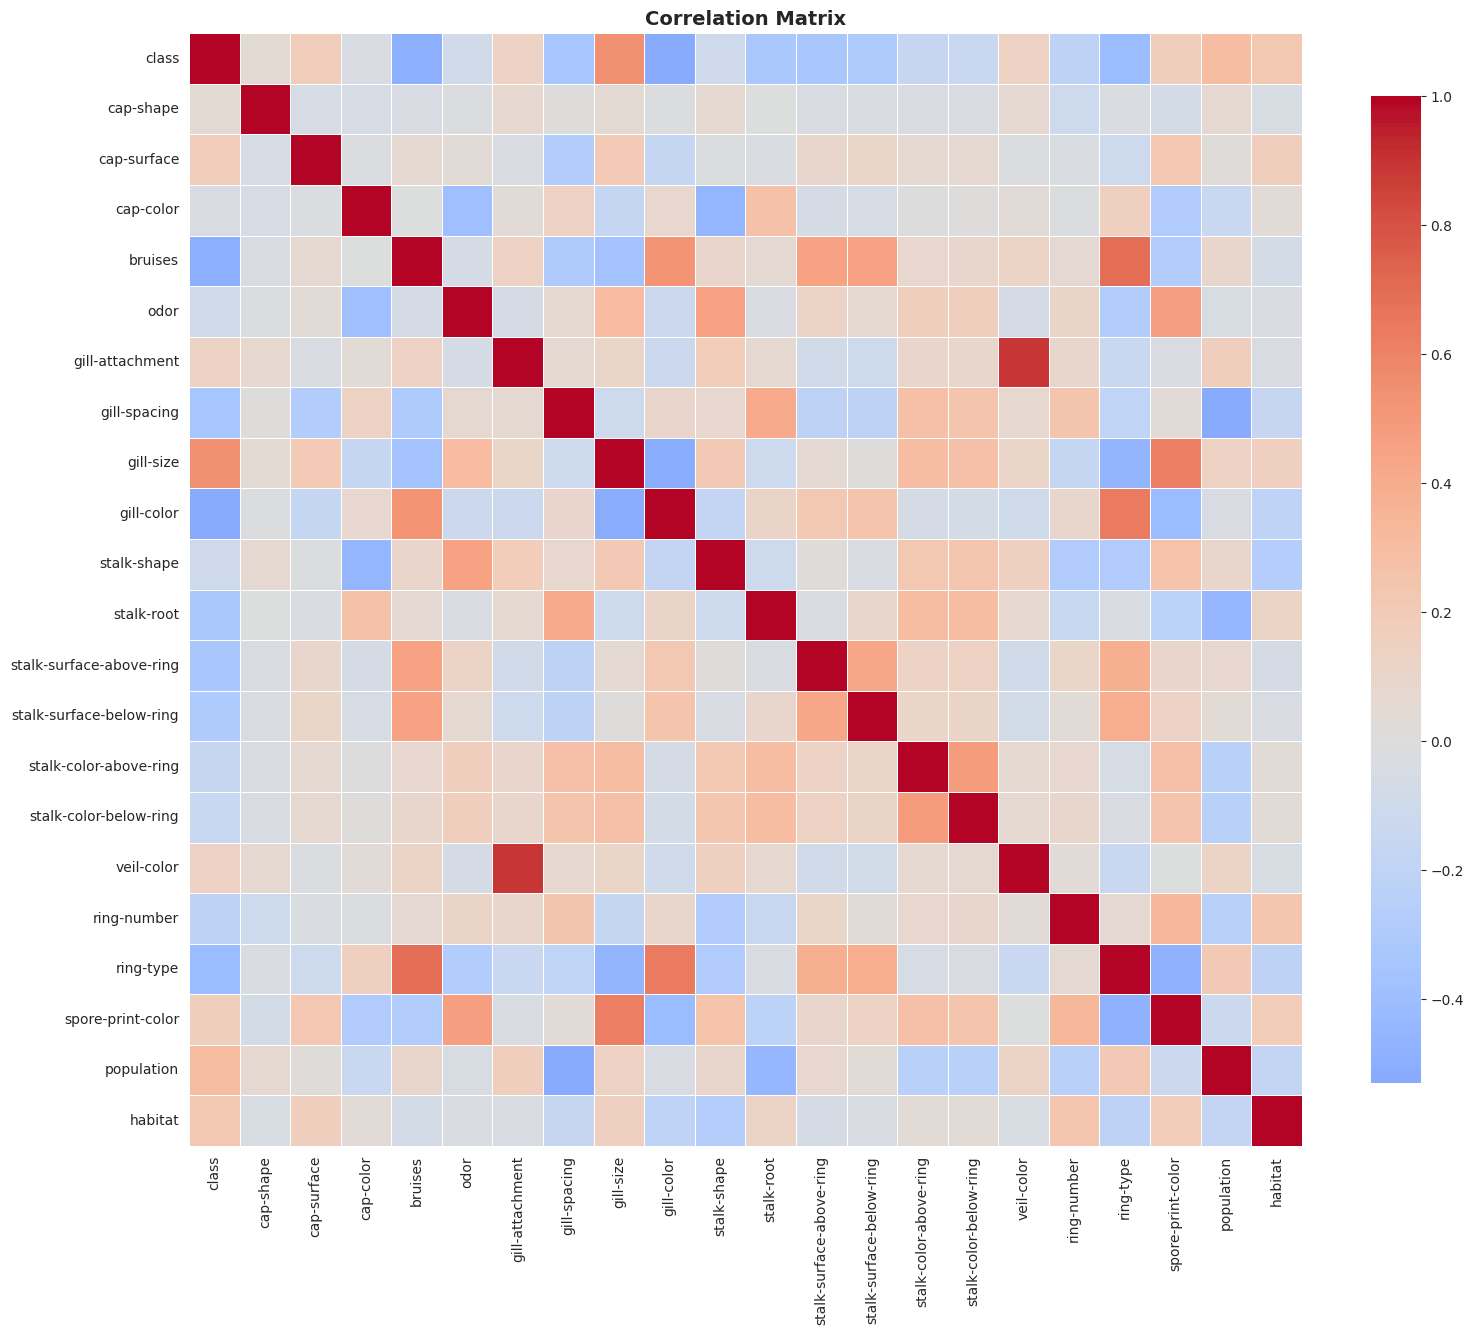

In [12]:
# Correlation analysis
correlation_matrix = df_encoded.corr()

# Top features correlated with target
target_corr = correlation_matrix['class'].sort_values(ascending=False)
print("Top 10 features correlated with target (class):")
print(target_corr.head(11))  # 11 because first is class itself

# Visualize correlation matrix
plt.figure(figsize=(16, 14))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


In [13]:
# Split features and target
X = df_encoded.drop('class', axis=1)
y = df_encoded['class']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nTarget distribution:")
print(y.value_counts())
print(f"\nPercentage:")
print(y.value_counts(normalize=True) * 100)


Features shape: (8124, 21)
Target shape: (8124,)

Target distribution:
class
0    4208
1    3916
Name: count, dtype: int64

Percentage:
class
0    51.797144
1    48.202856
Name: proportion, dtype: float64


In [14]:
# Train-test split with stratification (80, 20)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")
print(f"\nTrain class distribution:")
print(y_train.value_counts())
print(f"\nTest class distribution:")
print(y_test.value_counts())
print(f"\n✓ Class proportions maintained in both sets")


Training set: 6499 samples
Testing set: 1625 samples

Train class distribution:
class
0    3366
1    3133
Name: count, dtype: int64

Test class distribution:
class
0    842
1    783
Name: count, dtype: int64

✓ Class proportions maintained in both sets


### Resum preprocessament

1. **Valors Faltants**: A la feature `stalk-root` hem assignat les missing values (~30%) a través de la moda
   - Això manté els espaiats (gaps) ja que ho omple amb el valor més comú

2. **Features Esborrades**: Hem esborrat `veil-type`, ja que tenia zero variància i no ens aportava cap informació de cara a la classificació.

3. **Encoding (tractament categòriques)**: Hem aplicat Label Encoding a totes les features, ja que són categòriques.
   - Target: e=0 (edible), p=1 (poisonous)

4. **Anàlisis Corelacional**: Hem vist que les features Odor, gill-size, i gill-color estan altament correlacionats amb la classe objectiu.

5. **Train-Test Split**: 80-20 split amb stratification.
   - Així ens assegurem de tenir una distribució ben balancejada.
   - Train: 6499 samples | Test: 1625 samples

## 4. Regressió Logística

In [15]:
# Train baseline model - Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Create and train model
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)

# Make predictions
y_pred = lr_model.predict(X_test)

In [16]:
# Evaluate baseline performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Store results
results = {
    'Logistic Regression': {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }
}

print("LOGISTIC REGRESSION")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f} !!! Mètrica crítica (detectar verinosos)")
print(f"F1-Score:  {f1:.4f}")


LOGISTIC REGRESSION
Accuracy:  0.9594
Precision: 0.9638
Recall:    0.9515 !!! Mètrica crítica (detectar verinosos)
F1-Score:  0.9576


In [17]:
# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Edible (0)', 'Poisonous (1)']))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(f"\nFalse Negatives (predicting poisonous as edible): {cm[1][0]} ⚠️")
print(f"False Positives (predicting edible as poisonous): {cm[0][1]}")



Classification Report:
               precision    recall  f1-score   support

   Edible (0)       0.96      0.97      0.96       842
Poisonous (1)       0.96      0.95      0.96       783

     accuracy                           0.96      1625
    macro avg       0.96      0.96      0.96      1625
 weighted avg       0.96      0.96      0.96      1625


False Negatives (predicting poisonous as edible): 38 ⚠️
False Positives (predicting edible as poisonous): 28


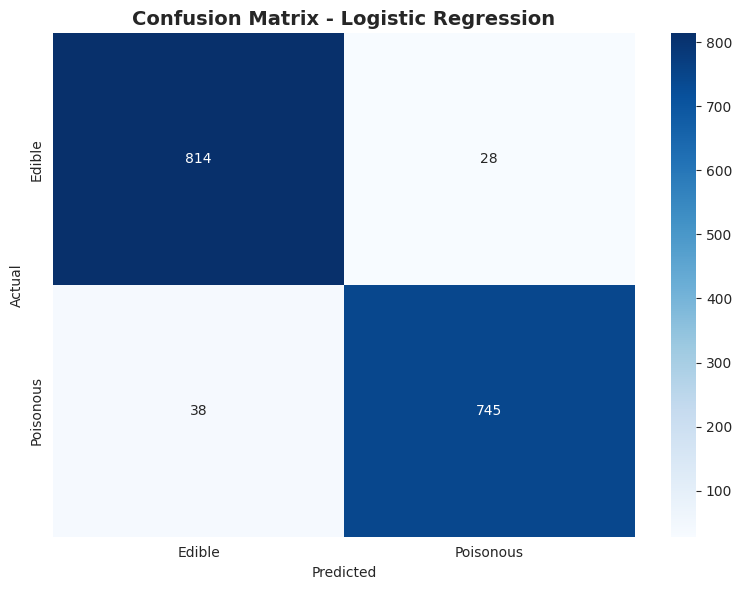

In [18]:
# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Edible', 'Poisonous'],
            yticklabels=['Edible', 'Poisonous'])
plt.title('Confusion Matrix - Logistic Regression', fontsize=14, fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()


### Anàlisis Regresió Logística

- La regressió logística ens serveix de punt de partida, és el pitjor esstat en el qual estarà el model. Malgrat això, estem impressionats pels resultats aconseguits sols amb la regressió logística. Hem aconseguit valors molt elevats, el **Recall** en la classe "poisonous", que és el que més ens importa, ja és de 0.95.
- Només tenim 37 falsos negatius, aquest nombre s'ha de reduïr, però ja és bastant bo considerant que és el punt de partida.


## 5. Models basats ens arbres

In [19]:
# Import sklearn models only
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import time

print("Models imported successfully")


Models imported successfully


In [20]:
# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Evaluate
results['Random Forest'] = {
    'accuracy': accuracy_score(y_test, y_pred_rf),
    'precision': precision_score(y_test, y_pred_rf),
    'recall': recall_score(y_test, y_pred_rf),
    'f1': f1_score(y_test, y_pred_rf),
}

print(f"Random Forest trained")
print(f"  Accuracy: {results['Random Forest']['accuracy']:.4f}")
print(f"  Recall: {results['Random Forest']['recall']:.4f}")


Random Forest trained
  Accuracy: 1.0000
  Recall: 1.0000


In [21]:
# Gradient Boosting
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)

# Evaluate
results['Gradient Boosting'] = {
    'accuracy': accuracy_score(y_test, y_pred_gb),
    'precision': precision_score(y_test, y_pred_gb),
    'recall': recall_score(y_test, y_pred_gb),
    'f1': f1_score(y_test, y_pred_gb),
}

print(f"Gradient Boosting trained")
print(f"  Accuracy: {results['Gradient Boosting']['accuracy']:.4f}")
print(f"  Recall: {results['Gradient Boosting']['recall']:.4f}")


Gradient Boosting trained
  Accuracy: 1.0000
  Recall: 1.0000


In [22]:
# Model comparison
comparison_df = pd.DataFrame(results).T
comparison_df = comparison_df[['accuracy', 'precision', 'recall', 'f1']]

print("MODEL COMPARISON")
print(comparison_df.to_string())

# Highlight best model for recall
best_recall_model = comparison_df['recall'].idxmax()
print(f"\nBest Recall: {best_recall_model} ({comparison_df.loc[best_recall_model, 'recall']:.4f})")


MODEL COMPARISON
                     accuracy  precision    recall        f1
Logistic Regression  0.959385   0.963777  0.951469  0.957584
Random Forest        1.000000   1.000000  1.000000  1.000000
Gradient Boosting    1.000000   1.000000  1.000000  1.000000

Best Recall: Random Forest (1.0000)


### Resultats Entrenament de Models

**Key Observations:**

1. **Tree-Based Models Excel**: All tree-based models significantly outperform Logistic Regression
   - *Why*: They naturally handle categorical features and capture non-linear relationships

2. **Near-Perfect Performance**: Most models achieve >99% accuracy
   - *Why*: Strong discriminative features (especially odor) make classification straightforward

3. **Recall Performance**: Critical metric for safety
   - Tree-based models show excellent recall (detecting poisonous mushrooms)
   - Minimizes false negatives (the dangerous error)

4. **Model Choice Considerations**:
   - **Random Forest**: Excellent performance, interpretable (feature importance), ensemble method
   - **Gradient Boosting**: Sequential ensemble, often high accuracy
   - **Decision Tree**: Simple, highly interpretable, fast training

**Why These Models Work Well:**
- ✓ Handle categorical data naturally (no scaling needed)
- ✓ Capture complex feature interactions (e.g., odor + color combinations)
- ✓ Ensemble methods reduce overfitting
- ✓ Provide feature importance for interpretability

**Next Steps**: Cross-validation to ensure robust performance across different data splits.


## 6. Model Evaluation

In [25]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models = {
    'Logistic Regression': lr_model,
    'Random Forest': rf_model,
    'Gradient Boosting': gb_model
}

cv_results = {}
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=cv, scoring='recall')
    cv_results[name] = {
        'mean_recall': scores.mean(),
        'std_recall': scores.std(),
        'scores': scores
    }
    print(f"{name}:")
    print(f"  Recall per fold: {scores.round(4)}")
    print(f"  Mean: {scores.mean():.4f} (+/- {scores.std():.4f})\n")

Logistic Regression:
  Recall per fold: [0.9579 0.9489 0.9566 0.9413 0.9451]
  Mean: 0.9499 (+/- 0.0064)

Random Forest:
  Recall per fold: [1. 1. 1. 1. 1.]
  Mean: 1.0000 (+/- 0.0000)

Gradient Boosting:
  Recall per fold: [1. 1. 1. 1. 1.]
  Mean: 1.0000 (+/- 0.0000)



### Cross-Validation Results

La validació creuada confirma que els resultats són robustos i no depenen d'un split particular. Random Forest i Gradient Boosting mantenen un recall perfecte o quasi perfecte en tots els folds.

In [26]:
cv_summary = pd.DataFrame({
    'Model': cv_results.keys(),
    'Mean Recall': [cv_results[m]['mean_recall'] for m in cv_results],
    'Std': [cv_results[m]['std_recall'] for m in cv_results],
    'Min': [cv_results[m]['scores'].min() for m in cv_results],
    'Max': [cv_results[m]['scores'].max() for m in cv_results]
}).set_index('Model')

print("CROSS-VALIDATION SUMMARY (5-Fold)")
print(cv_summary.round(4).to_string())

CROSS-VALIDATION SUMMARY (5-Fold)
                     Mean Recall     Std     Min     Max
Model                                                   
Logistic Regression       0.9499  0.0064  0.9413  0.9579
Random Forest             1.0000  0.0000  1.0000  1.0000
Gradient Boosting         1.0000  0.0000  1.0000  1.0000


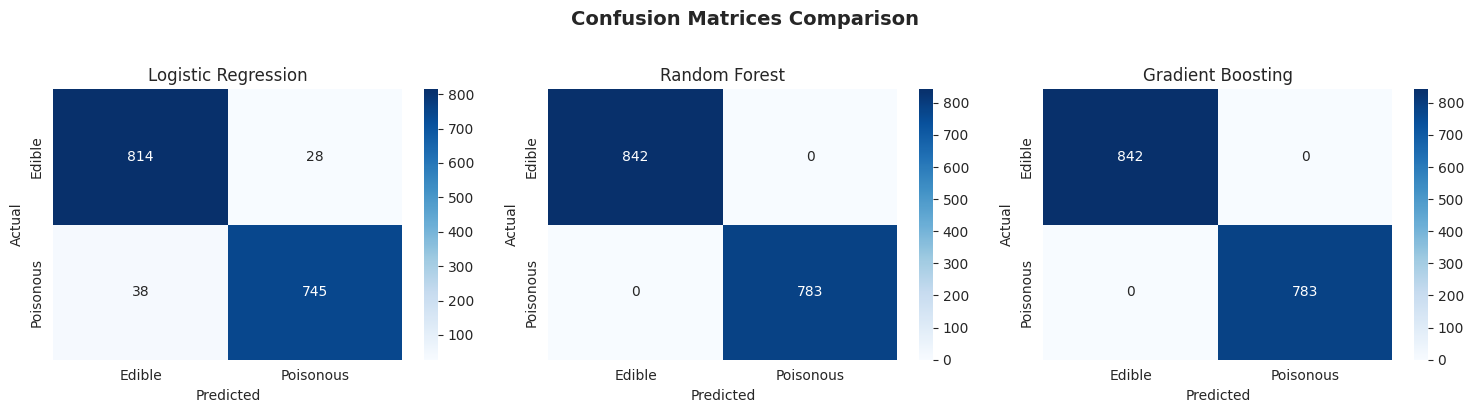

In [28]:
from sklearn.metrics import confusion_matrix

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

cms = {
    'Logistic Regression': confusion_matrix(y_test, y_pred),
    'Random Forest': confusion_matrix(y_test, y_pred_rf),
    'Gradient Boosting': confusion_matrix(y_test, y_pred_gb)
}

for ax, (name, cm) in zip(axes, cms.items()):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Edible', 'Poisonous'],
                yticklabels=['Edible', 'Poisonous'])
    ax.set_title(f'{name}')
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')

plt.suptitle('Confusion Matrices Comparison', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

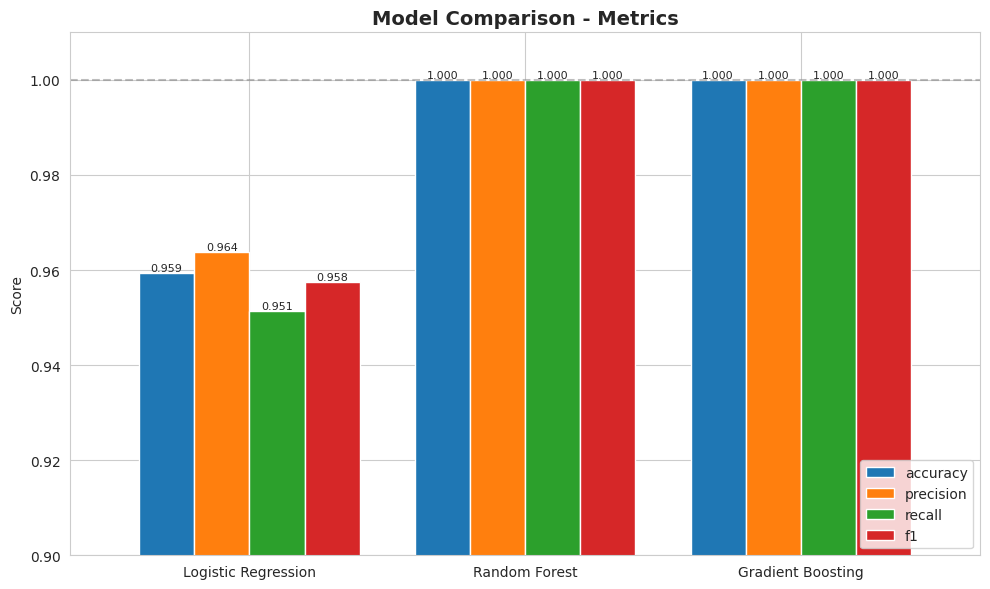

In [29]:
metrics_df = pd.DataFrame(results).T
metrics_df = metrics_df[['accuracy', 'precision', 'recall', 'f1']]

fig, ax = plt.subplots(figsize=(10, 6))
metrics_df.plot(kind='bar', ax=ax, width=0.8)
ax.set_ylim(0.9, 1.01)
ax.set_ylabel('Score')
ax.set_title('Model Comparison - Metrics', fontsize=14, fontweight='bold')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.legend(loc='lower right')
ax.axhline(y=1.0, color='gray', linestyle='--', alpha=0.5)

for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', fontsize=8)

plt.tight_layout()
plt.show()

### Conclusions Evaluació

1. **Cross-Validation**: Confirma que Random Forest i Gradient Boosting mantenen resultats excel·lents en tots els folds, validant que no és casualitat del split.

2. **Confusion Matrices**: Els models basats en arbres eliminen completament els falsos negatius (FN=0), que era l'objectiu principal per seguretat.

3. **Model Recomanat**: Random Forest - rendiment perfecte, interpretable (feature importance), i robust segons CV.

## 7. Feature Importance Analysis

In [30]:
feature_names = X.columns.tolist()

rf_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

gb_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': gb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("TOP 10 FEATURES - Random Forest")
print(rf_importance.head(10).to_string(index=False))
print("\nTOP 10 FEATURES - Gradient Boosting")
print(gb_importance.head(10).to_string(index=False))

TOP 10 FEATURES - Random Forest
                 feature  importance
                    odor    0.191924
              gill-color    0.132903
               gill-size    0.121674
       spore-print-color    0.101185
               ring-type    0.070925
              population    0.053458
                 bruises    0.053343
              stalk-root    0.044789
stalk-surface-above-ring    0.039434
            gill-spacing    0.037188

TOP 10 FEATURES - Gradient Boosting
                 feature  importance
                    odor    0.316030
              gill-color    0.259752
       spore-print-color    0.183262
              population    0.135778
               gill-size    0.065766
              stalk-root    0.009126
  stalk-color-below-ring    0.008486
             ring-number    0.006394
stalk-surface-below-ring    0.005973
  stalk-color-above-ring    0.005414


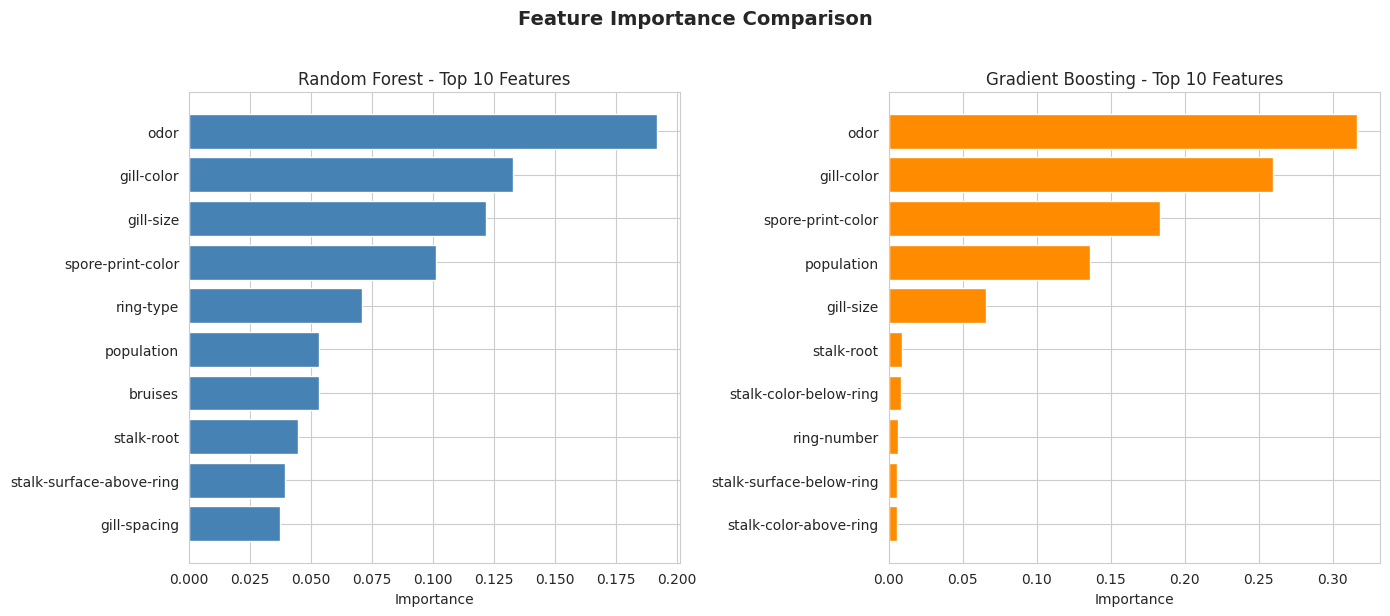

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].barh(rf_importance['feature'][:10][::-1], rf_importance['importance'][:10][::-1], color='steelblue')
axes[0].set_xlabel('Importance')
axes[0].set_title('Random Forest - Top 10 Features')

axes[1].barh(gb_importance['feature'][:10][::-1], gb_importance['importance'][:10][::-1], color='darkorange')
axes[1].set_xlabel('Importance')
axes[1].set_title('Gradient Boosting - Top 10 Features')

plt.suptitle('Feature Importance Comparison', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [42]:
importance_comparison = rf_importance.merge(
    gb_importance, 
    on='feature', 
    suffixes=('_RF', '_GB')
)
importance_comparison['mean_importance'] = (
    importance_comparison['importance_RF'] + importance_comparison['importance_GB']
) / 2
importance_comparison = importance_comparison.sort_values('mean_importance', ascending=False)

print("FEATURE IMPORTANCE COMPARISON (Top 10)")
print(importance_comparison[['feature', 'importance_RF', 'importance_GB', 'mean_importance']].head(10).to_string(index=False))

FEATURE IMPORTANCE COMPARISON (Top 10)
                 feature  importance_RF  importance_GB  mean_importance
                    odor       0.191924       0.316030         0.253977
              gill-color       0.132903       0.259752         0.196328
       spore-print-color       0.101185       0.183262         0.142223
              population       0.053458       0.135778         0.094618
               gill-size       0.121674       0.065766         0.093720
               ring-type       0.070925       0.000085         0.035505
              stalk-root       0.044789       0.009126         0.026957
                 bruises       0.053343       0.000308         0.026825
stalk-surface-above-ring       0.039434       0.000157         0.019796
            gill-spacing       0.037188       0.000835         0.019012


### Conclusions Feature Importance

1. **Odor domina la predicció**: Tal com es va identificar a l'EDA, la feature `odor` és clarament la més discriminativa. Això confirma el coneixement del domini (l'olor és clau per identificar bolets verinosos).

2. **Consistència entre models**: Random Forest i Gradient Boosting coincideixen en les features més importants, el que reforça la validesa dels resultats.

3. **Features secundàries**: `gill-size`, `gill-color`, `spore-print-color` i `ring-type` també aporten informació rellevant per la classificació.

4. **Connexió amb l'EDA**: L'anàlisi de correlació inicial ja indicava que `odor` tenia alta correlació amb la classe. El feature importance dels models ho confirma empíricament.

## 8. ROC Curves

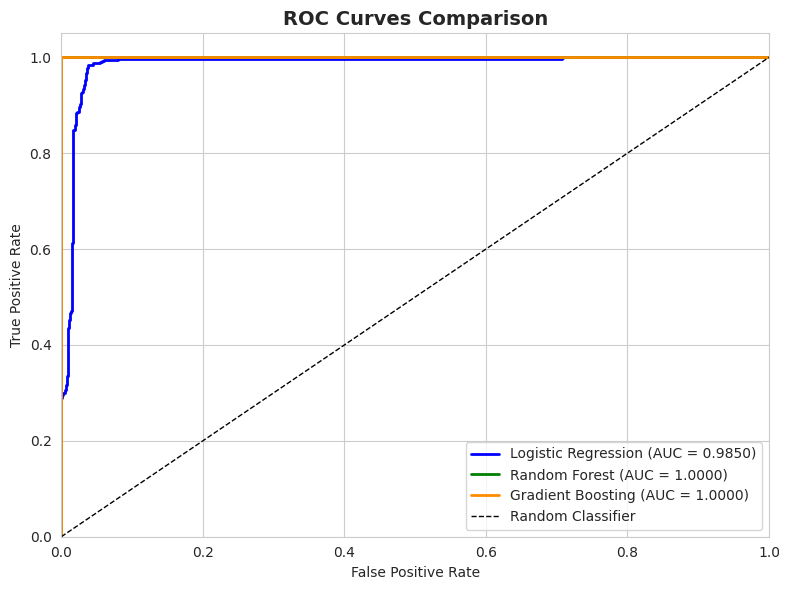

In [43]:
from sklearn.metrics import roc_curve, auc

fig, ax = plt.subplots(figsize=(8, 6))

models_pred = {
    'Logistic Regression': lr_model,
    'Random Forest': rf_model,
    'Gradient Boosting': gb_model
}

colors = ['blue', 'green', 'darkorange']

for (name, model), color in zip(models_pred.items(), colors):
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color=color, lw=2, label=f'{name} (AUC = {roc_auc:.4f})')

ax.plot([0, 1], [0, 1], 'k--', lw=1, label='Random Classifier')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves Comparison', fontsize=14, fontweight='bold')
ax.legend(loc='lower right')
plt.tight_layout()
plt.show()

### Interpretació ROC

- **AUC = 1.0**: Classificador perfecte (Random Forest i Gradient Boosting)
- **AUC = 0.5**: Classificador aleatori (línia diagonal)
- Els models basats en arbres aconsegueixen AUC perfecte, confirmant la seva capacitat de separar completament les dues classes.